# Calculate FID

In [1]:
import torch
import torchvision.models as models
import torchvision.transforms as transforms
from scipy.linalg import sqrtm
import numpy as np
from torch.utils.data import DataLoader
import torch
from torch import nn
import torchvision.utils as vutils
from torch.optim import Adam
from torch.utils.data import DataLoader,Dataset
import glob
from torchvision import transforms, datasets
from torchvision.utils import save_image
import os
import random
from PIL import Image
import itertools
import matplotlib.pyplot as plt
from torchvision.models import vgg19, resnet18
from torch.autograd import Variable
import numpy as np

# 加载 Inception 模型
model = models.inception_v3(pretrained=True, transform_input=False)
# 修改模型以输出适用于FID计算的特征
model.fc = nn.Identity()  # 将最后的全连接层替换为恒等映射，即输出特征图的全局平均池化结果
model.eval()
model.to('cuda')

def get_features(dataset):
    dataloader = DataLoader(dataset, batch_size=32, shuffle=False)
    features = []
    with torch.no_grad():
        for images in dataloader:
            images = images.to('cuda')
            output = model(images)
            features.append(output)  # 保留为tensor，避免转为numpy

    features = torch.cat(features, dim=0)  # 在GPU上连接
    mu = torch.mean(features, dim=0)
    sigma = torch.cov(features)
    print(mu)
    return mu, sigma  # 最后转换为numpy用于计算FID




def calculate_fid_torch(mu1, sigma1, mu2, sigma2, eps=1e-6):
    # # 将 numpy 数组转换为 torch 张量
    # mu1 = torch.from_numpy(mu1).to(torch.float32).cuda()
    # sigma1 = torch.from_numpy(sigma1).to(torch.float32).cuda()
    # mu2 = torch.from_numpy(mu2).to(torch.float32).cuda()
    # sigma2 = torch.from_numpy(sigma2).to(torch.float32).cuda()

    # 增加小的恒定值到协方巧的对角线上以提高数值稳定性
    sigma1 += torch.eye(sigma1.size(0)).cuda() * eps
    sigma2 += torch.eye(sigma2.size(0)).cuda() * eps

    ssdiff = torch.sum((mu1 - mu2) ** 2.0)
    
    # 计算 sigma1 和 sigma2 的乘积的平方根
    covmean = sqrtm_torch(sigma1.mm(sigma2))

    # 处理因数值不稳定导致的复数
    if torch.is_complex(covmean):
        covmean = covmean.real

    fid = ssdiff + torch.trace(sigma1 + sigma2 - 2 * covmean)
    return fid.item()

def sqrtm_torch(matrix):
    # 计算给定实对称矩阵的平方根
    u, s, v = torch.svd(matrix)
    return u @ torch.diag(torch.sqrt(s)) @ v.t()

# 使用 PyTorch 计算 FID 的示例
# mu1, sigma1, mu2, sigma2 应先定义并转换为适当的格式
# fid = calculate_fid_torch(mu1, sigma1, mu2, sigma2)





d:\Anaconda\envs\assignment2\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
d:\Anaconda\envs\assignment2\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [2]:
transform2 = transforms.Compose([
    transforms.Resize((256, 256)),  # 根据你的模型调整尺寸
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])


In [3]:
class ImageDataset(Dataset):
    def __init__(self, root='data', transforms_=None, unaligned=False, mode="train"):          ## (root = "./datasets/facades", unaligned=True:非对其数据)
        self.transform = transforms_                             ## transform变为tensor数据
        self.unaligned = unaligned

        self.files_A = sorted(glob.glob(os.path.join(root, mode) + "/*.*"))     ## "./datasets/facades/trainA/*.*"
        self.files_B = sorted(glob.glob(os.path.join(root, '%sB' % mode) + "/*.*"))     ## "./datasets/facades/trainB/*.*"

    def __getitem__(self, index):
        image_A = Image.open(self.files_A[index % len(self.files_A)])                   ## 在A中取一张照片

        # if self.unaligned:                                                              ## 如果采用非配对数据，在B中随机取一张
        #     image_B = Image.open(self.files_B[random.randint(0, len(self.files_B) - 1)])
        # else:
        #     image_B = Image.open(self.files_B[index % len(self.files_B)])

        # # 如果是灰度图，把灰度图转换为RGB图
        # if image_A.mode != "RGB":
        #     image_A = to_rgb(image_A)
        # if image_B.mode != "RGB":
        #     image_B = to_rgb(image_B)
        
        # 把RGB图像转换为tensor图, 方便计算，返回字典数据
        item_A = self.transform(image_A)
        # item_B = self.transform(image_B)
        return item_A

    ## 获取A,B数据的长度
    def __len__(self):
        return max(len(self.files_A), len(self.files_B))


In [5]:
# 用法
dataset1 = ImageDataset("human_dog", transforms_=transform2, unaligned=True, mode="test")
dataset2 = ImageDataset("generated", transforms_=transform2, unaligned=True, mode="test")
mu1, sigma1 = get_features(dataset1)
mu2, sigma2 = get_features(dataset2)
fid_value = calculate_fid_torch(mu1, sigma1, mu2, sigma2)


tensor([0.3736, 0.4454, 0.1865,  ..., 0.5271, 0.4784, 0.3087], device='cuda:0')
tensor([0.4498, 0.4556, 0.2110,  ..., 0.6699, 0.5226, 0.4144], device='cuda:0')


In [6]:
print(fid_value)

227.497314453125


In [7]:
dataset1 = ImageDataset("human_dog", transforms_=transform2, unaligned=True, mode="test")
dataset2 = ImageDataset("generated", transforms_=transform2, unaligned=True, mode="test2")
mu1, sigma1 = get_features(dataset1)
mu2, sigma2 = get_features(dataset2)
fid_value = calculate_fid_torch(mu1, sigma1, mu2, sigma2)

tensor([0.3736, 0.4454, 0.1865,  ..., 0.5271, 0.4784, 0.3087], device='cuda:0')
tensor([0.5984, 0.4471, 0.0945,  ..., 0.2993, 0.5707, 0.1480], device='cuda:0')


In [8]:
print(fid_value)

292.51348876953125


### Visualize result

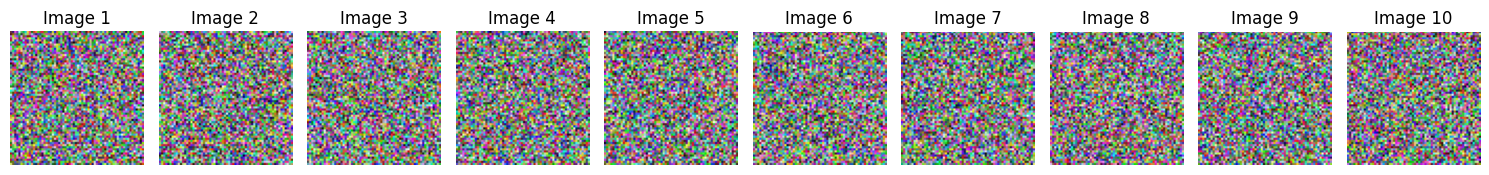

In [2]:
import matplotlib.pyplot as plt
import numpy as np

# 假设 images 是一个包含图像的列表，每个图像是一个 NumPy 数组
# 例如，images 可以是一个形状为 [10, height, width, channels] 的数组
# 这里我们创建一些随机数据来模拟这些图像
images = np.random.rand(10, 64, 64, 3)  # 10张64x64的RGB图像

# 创建一个 2x5 的子图网格
fig, axes = plt.subplots(nrows=1, ncols=10, figsize=(15, 6))

# 用于确保 axes 索引不会出错的小函数
axes = axes.ravel()

# 遍历所有图像和对应的坐标轴
for i, ax in enumerate(axes):
    ax.imshow(images[i])  # 显示图像
    ax.axis('off')  # 不显示坐标轴
    ax.set_title(f'Image {i+1}')  # 设置每个子图的标题

plt.tight_layout()  # 自动调整子图参数, 使之填充整个图像区域
plt.show()  # 显示图


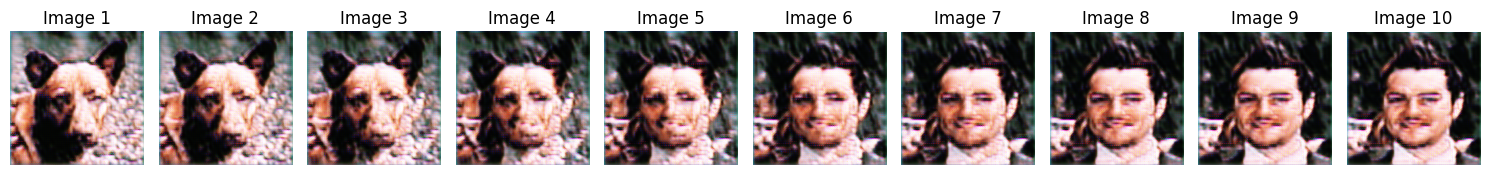

In [12]:
from PIL import Image
import matplotlib.pyplot as plt
import os

# 图像文件夹路径
image_folder = 'example'

# 获取文件夹中的前10个图像文件
image_files = [os.path.join(image_folder, f"test18_3 {i}.png") for i in range(1,11)][:10]

# 加载图像
images = [Image.open(file) for file in image_files]

# 创建一个 2x5 的子图网格
fig, axes = plt.subplots(nrows=1, ncols=10, figsize=(15, 6))
axes = axes.ravel()

# 显示图像
for i, ax in enumerate(axes):
    # 将Pillow图像转换为numpy数组
    img = np.array(images[i])
    ax.imshow(img)
    ax.axis('off')
    ax.set_title(f'Image {i+1}')

plt.tight_layout()
plt.show()


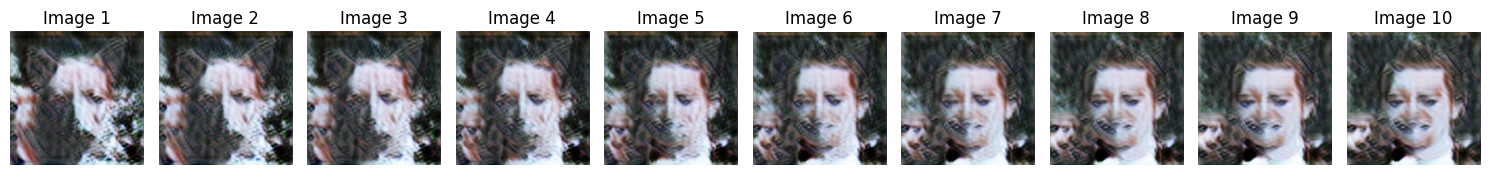

In [13]:
from PIL import Image
import matplotlib.pyplot as plt
import os

# 图像文件夹路径
image_folder = 'example'

# 获取文件夹中的前10个图像文件
image_files = [os.path.join(image_folder, f"test20 {i}.png") for i in range(1,11)][:10]

# 加载图像
images = [Image.open(file) for file in image_files]

# 创建一个 2x5 的子图网格
fig, axes = plt.subplots(nrows=1, ncols=10, figsize=(15, 6))
axes = axes.ravel()

# 显示图像
for i, ax in enumerate(axes):
    # 将Pillow图像转换为numpy数组
    img = np.array(images[i])
    ax.imshow(img)
    ax.axis('off')
    ax.set_title(f'Image {i+1}')

plt.tight_layout()
plt.show()
